# 🔋 Phase 3: Validasi EKF pada Profil Beban Dinamis (Urban Load)

**Tujuan Eksperimen:**
Memvalidasi performa algoritma *Extended Kalman Filter* (EKF) dalam mengestimasi *State of Charge* (SoC) dan tegangan terminal baterai LiFePO4 di bawah profil beban dinamis (simulasi fluktuasi arus rumah tangga).

**Metodologi:**
1. Mengekstrak parameter *Equivalent Circuit Model* (ECM) orde-1 ($R_0, R_1, C_1$) dari data HPPC.
2. Memuat kurva *Approximate OCV* dari hasil *Hysteresis Blending* (Pengujian Kapasitas).
3. Menginisialisasi *State-Space Model* EKF untuk memperbarui estimasi SoC berdasarkan observasi tegangan aktual (*Closed-loop feedback*).

**Dataset Input:**
1. `hppc (loop10x).csv` (Sumber parameter dinamis $R_0, R_1, C_1$)
2. `ocv_lookup_table.csv` (Sumber relasi Approximate OCV vs SoC)
3. `Dynamic Profiling (Urban Load).csv` (Data validasi beban dinamis)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Konfigurasi Tampilan Plot (Standar Jurnal)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

# =========================================================
# FUNGSI PEMBACA DATASETS (ZKETECH RAW DATA)
# =========================================================
def load_zke_data(filepath):
    skip_rows = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if "Time(S)" in line:
                skip_rows = i
                break
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df.columns = [col.strip() for col in df.columns]
    return df

### 1. Ekstraksi Parameter Berubah Terhadap Waktu (Time-Variant Parameters)
Fungsi relasi non-linear $OCV(SoC)$ dimuat menggunakan interpolasi. Turunan parsial $\frac{\partial OCV}{\partial SoC}$ digunakan untuk matriks Jacobian $H_k$. Parameter ECM diekstrak menggunakan regresi non-linear kuadrat terkecil (*Non-linear Least Squares*) pada setiap pulsa uji HPPC.

In [2]:
# =========================================================
# A. INISIALISASI APPROXIMATE OCV & JACOBIAN (dOCV/dSoC)
# =========================================================
df_ocv = pd.read_csv('ocv_lookup_table.csv')
f_OCV = interp1d(df_ocv['SoC'], df_ocv['True_OCV'], kind='linear', fill_value='extrapolate')

def get_dOCV_dSoC(soc):
    """
    Menghitung turunan pertama OCV terhadap SoC (Slope).
    Safeguard LiFePO4: Menghindari kemiringan negatif akibat noise pada area flat plateau.
    """
    delta = 0.001
    slope = (f_OCV(soc + delta) - f_OCV(soc - delta)) / (2 * delta)
    return max(0.001, float(slope)) 

# =========================================================
# B. EKSTRAKSI PARAMETER ECM (R0, R1, C1) DARI HPPC
# =========================================================
df_hppc = load_zke_data("hppc (loop10x).csv")

# Identifikasi periode transien (Pulse Discharge 10A)
is_pulse = (df_hppc['Cur(A)'] > 9.0) & (df_hppc['Cur(A)'] < 10.5)
pulse_starts = df_hppc.index[is_pulse.astype(int).diff() == 1].tolist()
pulse_ends = df_hppc.index[is_pulse.astype(int).diff() == -1].tolist()

results_rc = []
for i in range(min(len(pulse_starts), len(pulse_ends))):
    start, end = pulse_starts[i], pulse_ends[i]
    OCV = df_hppc.loc[start - 1, 'Vol(V)']
    t_start = df_hppc.loc[start, 'Time(S)']
    t = df_hppc.loc[start:end-1, 'Time(S)'] - t_start
    V = df_hppc.loc[start:end-1, 'Vol(V)']
    
    # R0 awal (Ohmic Drop)
    R0_guess = max((OCV - V.iloc[0]) / 10.0, 0.001)
    
    # Model Respon Tegangan Orde-1 (Thevenin)
    # V(t) = OCV - I*R0 - I*R1*(1 - e^(-t / (R1*C1)))
    def ecm(t, R0, R1, C1): 
        return OCV - 10.0 * R0 - 10.0 * R1 * (1 - np.exp(-t / (R1 * C1)))
    
    try:
        popt, _ = curve_fit(ecm, t, V, p0=[R0_guess, 0.01, 1000], bounds=(0, [1, 1, 100000]))
        results_rc.append({'SoC': (90 - i*10)/100.0, 'R0': popt[0], 'R1': popt[1], 'C1': popt[2]})
    except: 
        pass

df_rc = pd.DataFrame(results_rc).sort_values(by='SoC')

# Fungsi Lookup Table (Interpolasi) Parameter ECM
f_R0 = interp1d(df_rc['SoC'], df_rc['R0'], kind='linear', fill_value='extrapolate')
f_R1 = interp1d(df_rc['SoC'], df_rc['R1'], kind='linear', fill_value='extrapolate')
f_C1 = interp1d(df_rc['SoC'], df_rc['C1'], kind='linear', fill_value='extrapolate')

### 2. Formulasi State-Space Extended Kalman Filter (EKF)
Model matematis baterai dinyatakan dalam matriks diskrit:
**Vektor State ($x_k$):** $[SoC_k, V_{c1, k}]^T$
**Vektor Input ($u_k$):** $I_k$ (Arus Beban)
**Vektor Pengukuran ($z_k$):** $V_k$ (Tegangan Terminal)

**A. Tahap Prediksi (Time Update):**
$$x_{k|k-1} = A \cdot x_{k-1|k-1} + B \cdot u_k$$
$$P_{k|k-1} = A \cdot P_{k-1|k-1} \cdot A^T + Q$$

**B. Tahap Pembaruan (Measurement Update):**
$$K_k = P_{k|k-1} \cdot H^T \cdot (H \cdot P_{k|k-1} \cdot H^T + R)^{-1}$$
$$x_{k|k} = x_{k|k-1} + K_k \cdot (z_k - \hat{z}_k)$$
$$P_{k|k} = (I - K_k \cdot H) \cdot P_{k|k-1}$$

In [3]:
# =========================================================
# KELAS ALGORITMA EXTENDED KALMAN FILTER (EKF)
# =========================================================
class BatteryEKF_Dynamic:
    def __init__(self, Q_Ah, dt):
        self.Q = Q_Ah * 3600.0    # Kapasitas Baterai Nominal (Coulomb)
        self.dt = dt              # Periode Sampling (Detik)
        
        # Inisialisasi Vektor State [SoC, Vc1]
        self.x = np.array([[1.0], [0.0]])  
        
        # Inisialisasi Matriks Kovariansi Kesalahan (P)
        self.P = np.array([[0.01, 0.0], 
                           [0.0, 0.01]])
        self.Q_noise = np.array([[1e-6, 0.0], [0.0, 1e-5]])
        # Matriks Process Noise (Q) - Kredibilitas Integrasi Arus
        self.R_noise = np.array([[1e-2]])
        

    def step(self, I, V_meas):
        # Ekstraksi state terkini dengan batasan saturasi
        soc = np.clip(float(self.x[0, 0]), 0.01, 0.99)
        vc1 = float(self.x[1, 0])
        
        # Evaluasi parameter non-linear pada iterasi ke-k
        R0 = float(f_R0(soc))
        R0 = min(R0, 0.02)
        R1 = float(f_R1(soc))
        C1 = float(f_C1(soc))
        OCV = float(f_OCV(soc))
        
        # ==========================================
        # TAHAP 1: PREDICTION (A PRIORI)
        # ==========================================
        # Integrasi arus (Coulomb Counting)
        soc_pred = soc - (I * self.dt / self.Q)
        
        # Respon tegangan polarisasi
        exp_term = np.exp(-self.dt / (R1 * C1))
        vc1_pred = vc1 * exp_term + R1 * (1 - exp_term) * I
        
        self.x = np.array([[soc_pred], [vc1_pred]])
        
        # Matriks Jacobian Transisi (A)
        A = np.array([[1.0, 0.0], 
                      [0.0, exp_term]])
        
        # Prediksi Matriks Kovariansi Kesalahan (P)
        self.P = A @ self.P @ A.T + self.Q_noise
        
        # ==========================================
        # TAHAP 2: UPDATE (A POSTERIORI)
        # ==========================================
        # Persamaan Output / Prediksi Tegangan Terminal
        V_pred = OCV - vc1_pred - (I * R0)
        
        # Matriks Jacobian Pengukuran (H)
        H = np.array([[get_dOCV_dSoC(soc_pred), -1.0]])
        
        # Inovasi Kovariansi (S) dan Kalman Gain (K)
        S = H @ self.P @ H.T + self.R_noise
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Kalkulasi Error (Residual)
        error = V_meas - V_pred
        
        # Pembaruan Vektor State (Koreksi)
        self.x = self.x + (K * error)
        
        # Pembaruan Matriks Kovariansi Kesalahan (P)
        self.P = (np.eye(2) - K @ H) @ self.P
        
        return float(self.x[0, 0]), V_pred

### 3. Eksekusi Model pada Profil Beban Dinamis (Urban Load)
Menguji keandalan estimasi EKF terhadap data pengukuran dunia nyata yang memuat profil pembebanan fluktuatif (simulasi aktivitas kelistrikan rumah tangga).

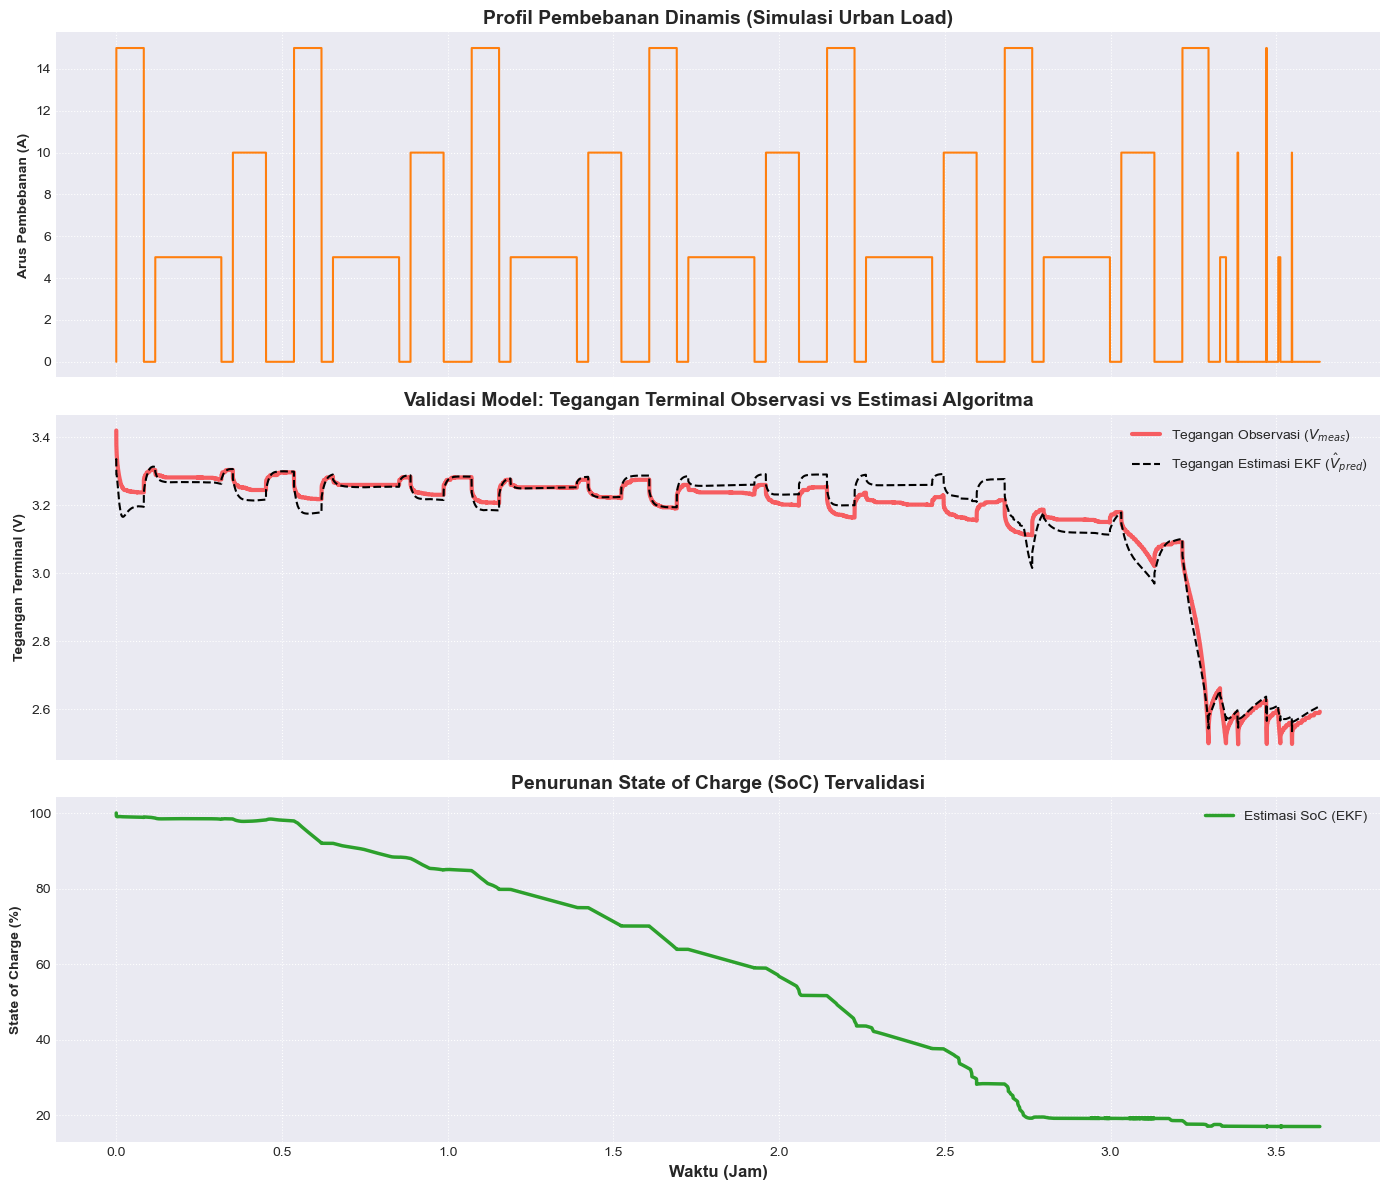

In [4]:
# =========================================================
# INITIALIZATION & EXECUTION
# =========================================================
# Memuat Data Validasi Dinamis
df_dyn = load_zke_data("Dynamic Profiling (Urban Load).csv")

# Mengalkulasi nilai aktual delta t dari log instrumentasi
dt_actual = df_dyn['Time(S)'].diff().median()

# Kapasitas Aktual Baterai (Ah) -> Diperoleh dari Ekstraksi Phase 2b
Q_aktual = 20.80 

# Inisialisasi Objek EKF
ekf = BatteryEKF_Dynamic(Q_Ah=Q_aktual, dt=dt_actual)

soc_history = []
v_pred_history = []

# Loop iterasi State-Space berdasarkan observasi waktu-nyata
for i in range(len(df_dyn)):
    soc_est, v_pred = ekf.step(I=df_dyn['Cur(A)'].iloc[i], V_meas=df_dyn['Vol(V)'].iloc[i])
    soc_history.append(soc_est * 100) # Persentase
    v_pred_history.append(v_pred)

df_dyn['SoC_EKF (%)'] = soc_history
df_dyn['V_Pred (V)'] = v_pred_history

# =========================================================
# VISUALISASI HASIL VALIDASI
# =========================================================
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 12))
time_hrs = df_dyn['Time(S)'] / 3600

# 1. Plot Profil Beban Arus (Disturbance)
ax1.plot(time_hrs, df_dyn['Cur(A)'], color='tab:orange', linewidth=1.5)
ax1.set_ylabel('Arus Pembebanan (A)', fontweight='bold')
ax1.set_title('Profil Pembebanan Dinamis (Simulasi Urban Load)', fontweight='bold', fontsize=14)
ax1.grid(True, linestyle=':')

# 2. Plot Validasi Estimasi Tegangan Terminal
ax2.plot(time_hrs, df_dyn['Vol(V)'], label='Tegangan Observasi ($V_{meas}$)', color='red', alpha=0.6, linewidth=3)
ax2.plot(time_hrs, df_dyn['V_Pred (V)'], label='Tegangan Estimasi EKF ($\hat{V}_{pred}$)', color='black', linestyle='--', linewidth=1.5)
ax2.set_ylabel('Tegangan Terminal (V)', fontweight='bold')
ax2.set_title('Validasi Model: Tegangan Terminal Observasi vs Estimasi Algoritma', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle=':')

# 3. Plot Estimasi State of Charge (SoC)
ax3.plot(time_hrs, df_dyn['SoC_EKF (%)'], color='tab:green', linewidth=2.5, label='Estimasi SoC (EKF)')
ax3.set_xlabel('Waktu (Jam)', fontweight='bold', fontsize=12)
ax3.set_ylabel('State of Charge (%)', fontweight='bold')
ax3.set_title('Penurunan State of Charge (SoC) Tervalidasi', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(True, linestyle=':')

plt.tight_layout()
plt.show()